# Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import datetime as dt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
from PIL import Image 


Bad key "text.kerning_factor" on line 4 in
/Users/bogt/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
users_df = pd.read_csv(r'./Scraping/data/uber_users.csv') # Per user data
uber_df = pd.read_pickle(r'./data/uber_tk.p')
uber_df_copy = uber_df.copy()
# Delete index column
users_df.drop(users_df.columns[0], axis=1, inplace=True)
users_df_copy = users_df.copy()

In [3]:
covid_date = np.datetime64('2020-04-01T01:00:00.000000+0100')

/Users/bogt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


In [4]:
users_df.head()

user  listed  followers
0  Michael05914091       0          8
1        ShieldVoC      18      17566
2          fltrtae      15       1717
3    Lucky00890359       0          0
4  zhenyalindgardt       1         55

In [5]:
uber_df.head()

source           source_id         target   target_id  \
0  Uber_Support          2815754953  wordofbrandon  2566081240   
1  Uber_Support          2815754953  wordofbrandon  2566081240   
2  Uber_Support          2815754953      CapeVgirl   719534538   
3  Uber_Support          2815754953      CapeVgirl   719534538   
4  SatishInnov8  722043526461145088   Uber_Support  2815754953   

  type_of_content          created_at  \
0           Reply 2019-08-31 10:53:53   
1           Reply 2019-08-31 10:53:53   
2           Reply 2019-10-01 07:45:30   
3           Reply 2019-10-01 07:45:30   
4           Reply 2019-12-09 17:11:51   

                                            all_data  \
0  {'created_at': 'Sat Aug 31 10:53:53 +0000 2019...   
1  {'created_at': 'Sat Aug 31 10:53:53 +0000 2019...   
2  {'created_at': 'Tue Oct 01 07:45:30 +0000 2019...   
3  {'created_at': 'Tue Oct 01 07:45:30 +0000 2019...   
4  {'created_at': 'Mon Dec 09 17:11:51 +0000 2019...   

                                                text  
0  [thanks, bringing, attention, team, currently,...  
1  [thanks, bringing, attention, team, currently,...  
2  [help, suggest, restarting, app, work, reset, ...  
3  [help, suggest, restarting, app, work, reset, ...  
4  [wish, respectfully, state, regular, user, usi...

In [6]:
uber_df['all_data'][0]

{'created_at': 'Sat Aug 31 10:53:53 +0000 2019',
 'id': 1167752362733293568,
 'id_str': '1167752362733293568',
 'text': '@wordofbrandon Thanks for bringing this to our attention, @wordofbrandon. Our team is currently reviewing and will… https://t.co/9laWax1Uoh',
 'truncated': True,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'wordofbrandon',
    'name': 'Brandon Jones',
    'id': 2566081240,
    'id_str': '2566081240',
    'indices': [0, 14]},
   {'screen_name': 'wordofbrandon',
    'name': 'Brandon Jones',
    'id': 2566081240,
    'id_str': '2566081240',
    'indices': [58, 72]}],
  'urls': [{'url': 'https://t.co/9laWax1Uoh',
    'expanded_url': 'https://twitter.com/i/web/status/1167752362733293568',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [116, 139]}]},
 'source': '<a href="https://www.sprinklr.com" rel="nofollow">Sprinklr</a>',
 'in_reply_to_status_id': 1167748661633142784,
 'in_reply_to_status_id_str': '11677486616331

# All Network

In [7]:
uber_df['type_of_content'].value_counts()

Reply      5253
Mention     254
Tweet        61
Name: type_of_content, dtype: int64

In [8]:
# Calculate types per user
users_df['reply_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('source')['type_of_content'].transform('count'))
users_df['reply_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('target')['type_of_content'].transform('count'))
users_df['mention_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('source')['type_of_content'].transform('count'))
users_df['mention_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('target')['type_of_content'].transform('count'))
users_df['tweet_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('source')['type_of_content'].transform('count'))
users_df['tweet_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('target')['type_of_content'].transform('count'))

In [9]:
users_df.describe()

listed     followers   reply_sent  reply_recieved  mention_sent  \
count    2578.000000  2.578000e+03  2502.000000     2502.000000     63.000000   
mean      133.553142  5.738144e+04   262.248601     1992.258993      4.714286   
std      3042.780387  1.213325e+06   480.116203     1489.011667      4.598136   
min         0.000000  0.000000e+00     1.000000        1.000000      1.000000   
25%         0.000000  3.000000e+00     1.000000        5.250000      1.000000   
50%         0.000000  3.500000e+01     2.000000     3126.000000      3.000000   
75%         3.000000  2.492500e+02     9.000000     3126.000000      8.000000   
max    147751.000000  5.338561e+07  1149.000000     3126.000000     13.000000   

       mention_recieved  tweet_sent  tweet_recieved  
count         63.000000   13.000000       13.000000  
mean          72.190476    2.000000        2.000000  
std           42.185786    1.414214        1.414214  
min            1.000000    1.000000        1.000000  
25%           22.000000    1.000000        1.000000  
50%           65.000000    1.000000        1.000000  
75%          115.000000    4.000000        4.000000  
max          115.000000    4.000000        4.000000

In [10]:
users_df.fillna(0, inplace=True) # Consitency
users_df

user  listed  followers  reply_sent  reply_recieved  \
0     Michael05914091       0          8      1149.0             3.0   
1           ShieldVoC      18      17566      1149.0             3.0   
2             fltrtae      15       1717      1149.0             4.0   
3       Lucky00890359       0          0      1149.0             4.0   
4     zhenyalindgardt       1         55         3.0          3126.0   
...               ...     ...        ...         ...             ...   
2573    fayedicksonxo       0        213         1.0          3126.0   
2574     Iam_bahuguna       0         90         1.0          3126.0   
2575         ajb_neuk       0          3         0.0             0.0   
2576           k_sovs       0          2         0.0             0.0   
2577        MY0U1SANA      22       3946         1.0          3126.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2573           0.0               0.0         0.0             0.0  
2574           0.0               0.0         0.0             0.0  
2575           8.0             115.0         0.0             0.0  
2576           8.0               2.0         0.0             0.0  
2577           0.0               0.0         0.0             0.0  

[2578 rows x 9 columns]

In [11]:
# Create network
G = nx.DiGraph()

edges = list()
for (a,b) in zip(uber_df['source'], uber_df['target']):
    edges.append((a,b))

G.add_edges_from(edges)
G

In [44]:
from networkx.algorithms import community
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))

[['103sanaiqbal',
  '123aviraj',
  '1975aregr8t',
  '1BirdyTheMighty',
  '1Lucasmeireles',
  '2019Express',
  '212killakam',
  '21stEnglish',
  '2376d31290e44e6',
  '3ebfandan',
  '3stagesofgirl',
  '4AtruDiva',
  '4dpeople1',
  '5t0Ba6QDN1yqeUv',
  '6athory',
  '7mmd2',
  '82vemnz',
  '87_side',
  '9252768',
  '9988SARKAR',
  '99Tahona',
  '9lru7hu7Kb30xG4',
  'AAKASHBHARATI3',
  'AAjitabh',
  'ABHISHEK1979MAY',
  'AContrerasVE',
  'AEronStrife2',
  'AFALAMBULBUL1',
  'AH46964879',
  'ALFARAZIALAM1',
  'AOLuther',
  'AZCloutGodz',
  'Aaliyaa1x',
  'AapKaGopalRai',
  'AaronHa99514664',
  'AaronsCrafts',
  'Aashin_A_Shah',
  'AasifSayeed2',
  'AbasNasiro',
  'AbdulRa10911356',
  'Abel_Seloane',
  'Abhi_Banerjee12',
  'Abhiji0597',
  'Abhishe82985772',
  'Abhishektornedo',
  'AbluntIndian',
  'Abrar61099205',
  'AcreUK',
  'AdamCadot',
  'AdemsWorld',
  'AdesuaOkosuns',
  'Adhurikhwaishen',
  'Adityakhemka16',
  'AdrianMatache7',
  'AdrianaStills',
  'AdwMacs',
  'Aelarie1',
  'Afework14

In [75]:
user_communities=[]
index=0
for community in next_level_communities:
    user_communities.extend(list(zip(community,[index]*len(next_level_communities[0]))))
    index+=1

In [78]:
communties=pd.DataFrame(user_communities)
communties.columns=['source','group']
communties.to_csv("Communities.csv")

In [99]:
from networkx.algorithms.community import k_clique_communities
# Create network
G2 = nx.Graph()

edges = list()
for (a,b) in zip(uber_df['source'], uber_df['target']):
    edges.append((a,b))

G2.add_edges_from(edges)

#K5 = nx.convert_node_labels_to_integers(G2, first_label=2)
G2.add_edges_from(K5.edges())
c= list(k_clique_communities(G2,3))

In [181]:
"|".join(list(c[100]))

'Shauryayawhaaat|Uber|PushkarTweeting'

In [192]:
cliques=pd.DataFrame()
index=0
for clique in c:
    #cliques.extend(list(zip(list(clique),[index]*len(clique))))
    # list(itertools.product(*list(c[0])))
    if(type(list(clique)[0])==str):
        people="|".join(list(clique))
        containing=uber_df[(uber_df['source'].str.contains(people)) & (uber_df['target'].str.contains(people))]
    #     containing=uber_df[uber_df['target'].str.contains(people)]
        clique=containing
        clique['clique']=index
        cliques=cliques.append(clique)
        index+=1
#     list1 = list(clique)
#     list2 = list(clique)
#     if(type(list1[0])!=int):
#         all_combinations = [list(zip(each_permutation, list2)) for each_permutation in itertools.permutations(list1, len(list2))]
#         all_combinations= [item for sublist in all_combinations for item in sublist]
#         all_combinations=pd.DataFrame(all_combinations)
#         all_combinations['clique']=index
#         cliques=cliques.append(all_combinations)
#     index+=1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [190]:
cliques

source            source_id           target   target_id  \
1398   Uber_Support           2815754953     Uber_Support  2815754953   
1399   Uber_Support           2815754953     Uber_Support  2815754953   
1400   Uber_Support           2815754953     Uber_Support  2815754953   
1401   Uber_Support           2815754953     Uber_Support  2815754953   
2455    eliyahcodex  1073054111107555328  Racheljoyknight  2153887778   
...             ...                  ...              ...         ...   
2333     Abhiji0597  1354081530038120452             Uber    19103481   
2334     Abhiji0597  1354081530038120452     Uber_Support  2815754953   
2996   tashaperry83            794471311         UberEats  3100005042   
3042  rodrigosabato  1265603694021640196     tashaperry83   794471311   
3043  rodrigosabato  1265603694021640196         UberEats  3100005042   

     type_of_content          created_at  \
1398           Tweet 2021-03-22 13:20:18   
1399           Tweet 2021-03-22 13:20:18   
1400           Tweet 2021-03-22 13:20:18   
1401           Tweet 2021-03-22 13:20:18   
2455           Reply 2021-03-27 13:14:13   
...              ...                 ...   
2333           Reply 2021-03-27 05:47:42   
2334           Reply 2021-03-27 05:47:42   
2996           Reply 2021-03-28 23:57:14   
3042           Reply 2021-03-29 01:42:38   
3043           Reply 2021-03-29 01:42:38   

                                               all_data  \
1398  {'created_at': 'Mon Mar 22 13:20:18 +0000 2021...   
1399  {'created_at': 'Mon Mar 22 13:20:18 +0000 2021...   
1400  {'created_at': 'Mon Mar 22 13:20:18 +0000 2021...   
1401  {'created_at': 'Mon Mar 22 13:20:18 +0000 2021...   
2455  {'created_at': 'Sat Mar 27 13:14:13 +0000 2021...   
...                                                 ...   
2333  {'created_at': 'Sat Mar 27 05:47:42 +0000 2021...   
2334  {'created_at': 'Sat Mar 27 05:47:42 +0000 2021...   
2996  {'created_at': 'Sun Mar 28 23:57:14 +0000 2021...   
3042  {'created_at': 'Mon Mar 29 01:42:38 +0000 2021...   
3043  {'created_at': 'Mon Mar 29 01:42:38 +0000 2021...   

                                                   text  clique  
1398  [hi, happy, help, please, follow, support, pag...       0  
1399  [hi, happy, help, please, follow, support, pag...       0  
1400  [hi, happy, help, please, follow, support, pag...       0  
1401  [hi, happy, help, please, follow, support, pag...       0  
2455  [racheljoyknight, ubersupport, eliyahcodex, bi...       0  
...                                                 ...     ...  
2333  [madhukishwar, uber, ubersupport, expect, acti...       0  
2334  [madhukishwar, uber, ubersupport, expect, acti...       0  
2996  [ubereats, waiting, six, hour, response, issue...       0  
3042  [ubereats, wait, wait, thats, answer, wheres, ...       0  
3043  [ubereats, wait, wait, thats, answer, wheres, ...       0  

[1237 rows x 9 columns]

In [193]:
cliques.reset_index(drop=True).to_csv("Some_cliques.csv")

In [ ]:
cliques=pd.DataFrame(cliques)
cliques.columns=['source','target','clique']
cliques.to_csv("cliques.csv")

In [114]:
pickle.dump(c,open('cliques.p','wb'))

In [56]:
communities=[top_level_communities ,next_level_communities]
import pickle
pickle.dump(communities,open('communities.p','wb'))

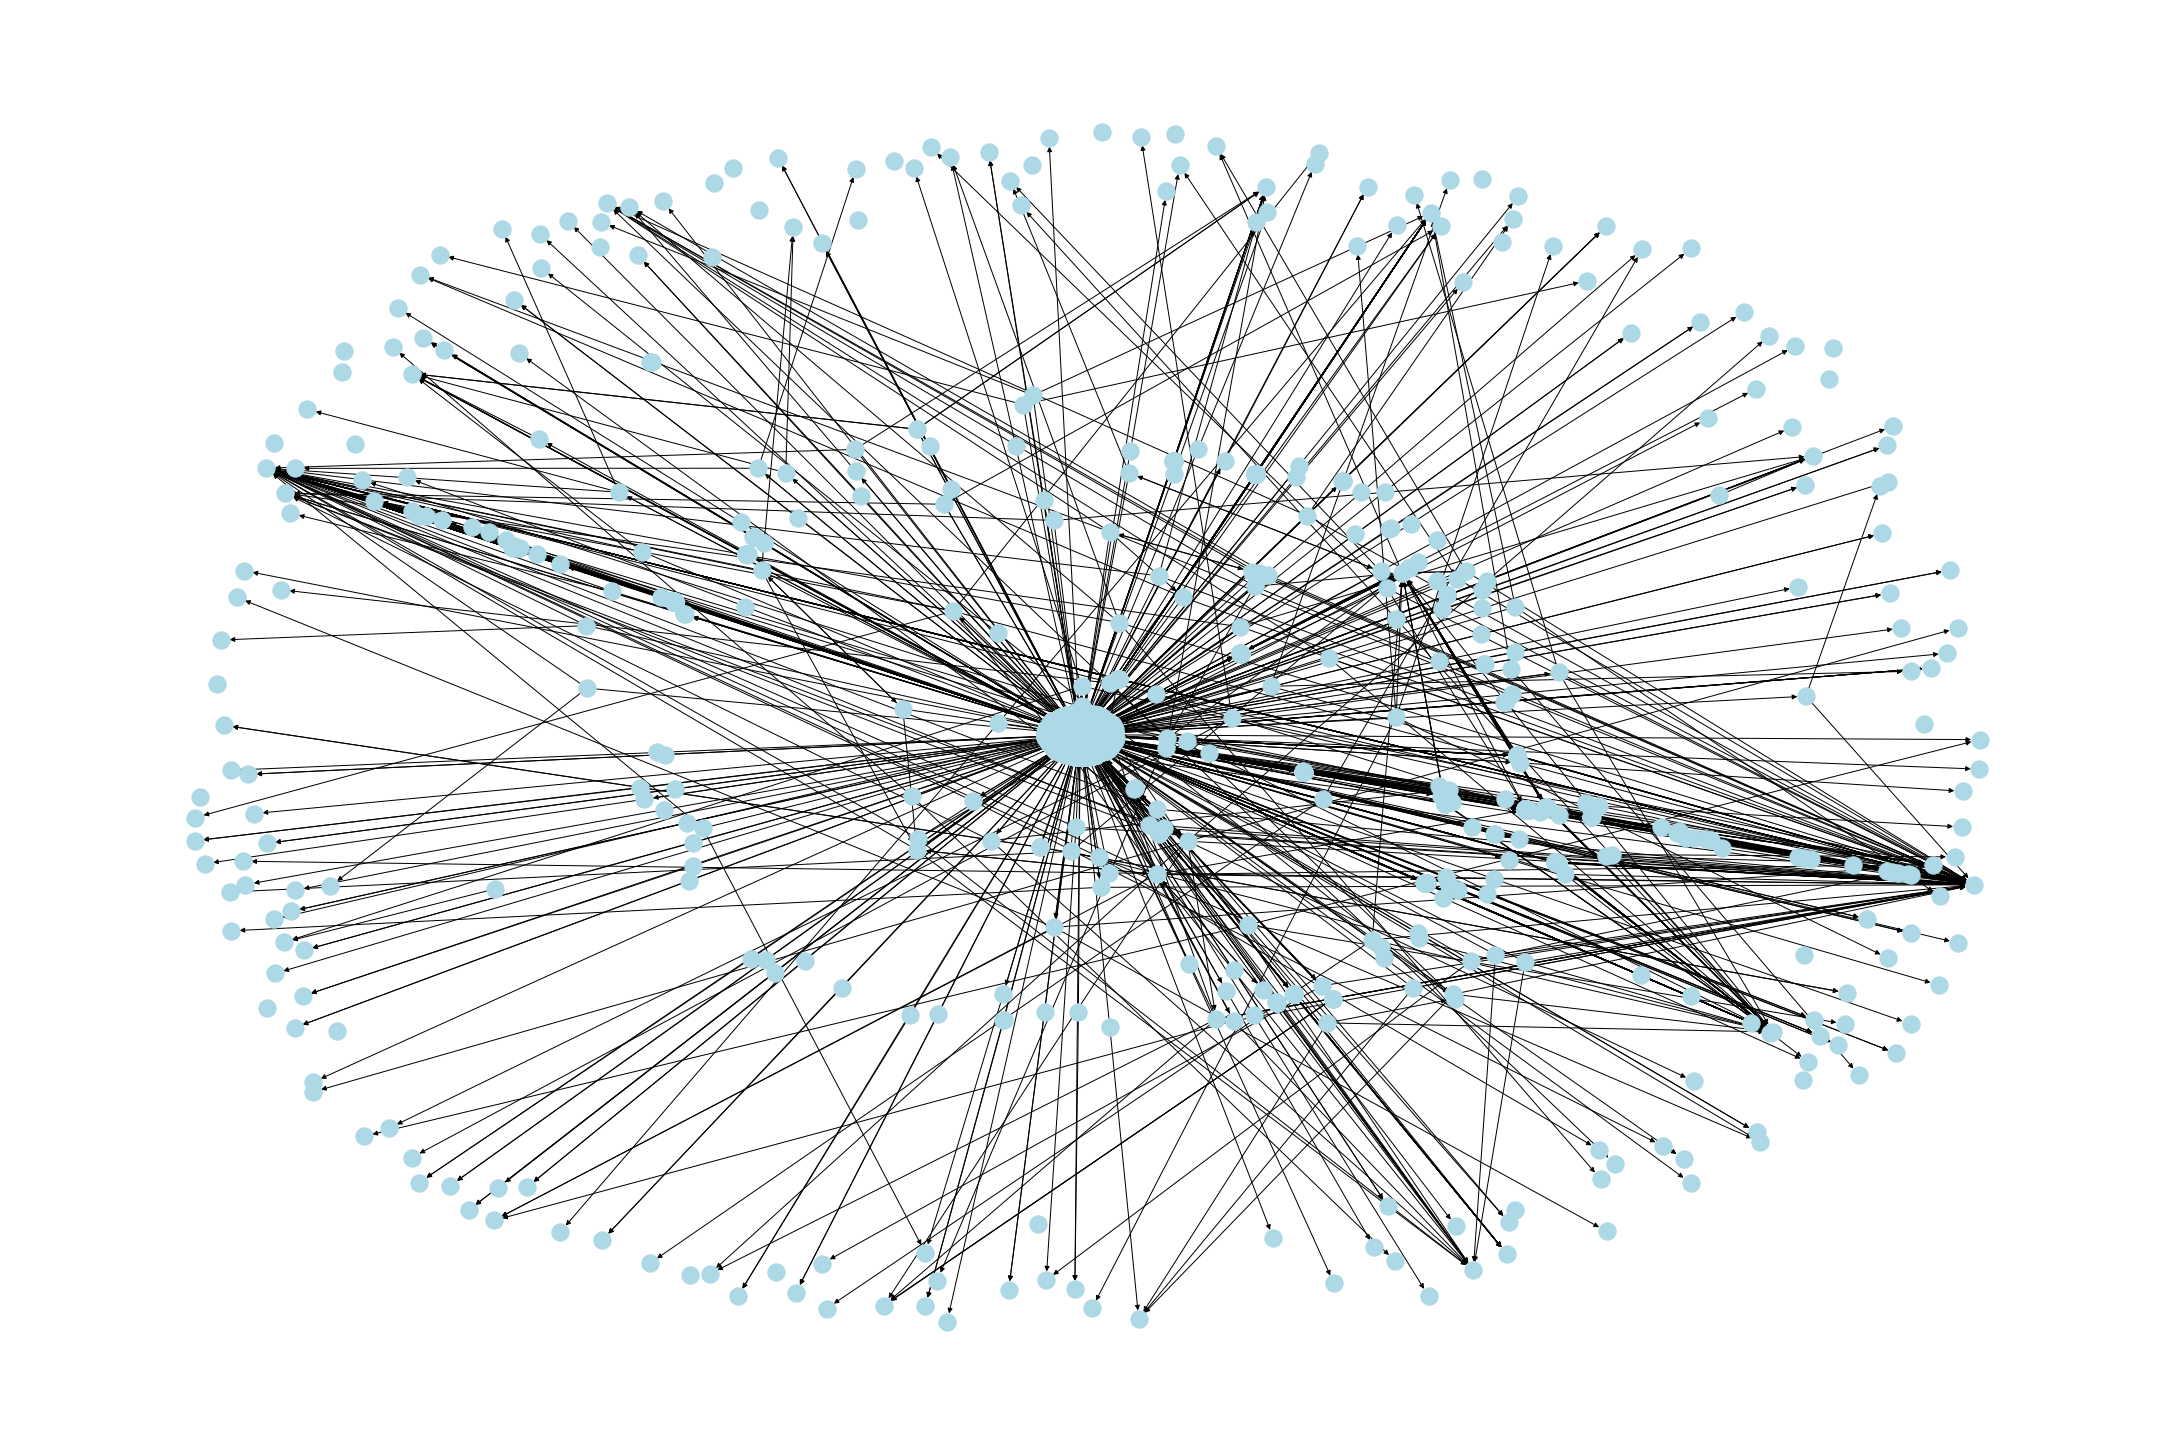

In [12]:
rcParams['figure.figsize'] = 30, 20
pos = nx.spring_layout(G, scale=0.15, k=0.5/np.sqrt(G.order()))
nx.draw(G, pos, node_color='lightblue')

In [13]:
degree_centrality=pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').reset_index()
degree_centrality

index         0
0      Uber_Support  1.215641
1     wordofbrandon  0.000774
2         CapeVgirl  0.000774
3      SatishInnov8  0.000774
4        realchetty  0.000774
...             ...       ...
2579        Nezz911  0.001161
2580    NeoVonAxiom  0.000387
2581       ajb_neuk  0.000774
2582   Iam_bahuguna  0.000387
2583      MY0U1SANA  0.000774

[2584 rows x 2 columns]

In [14]:
closeness_centrality=pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index').reset_index()
closeness_centrality

index         0
0      Uber_Support  0.897051
1     wordofbrandon  0.450255
2         CapeVgirl  0.450255
3      SatishInnov8  0.000000
4        realchetty  0.449965
...             ...       ...
2579        Nezz911  0.449965
2580    NeoVonAxiom  0.000000
2581       ajb_neuk  0.449965
2582   Iam_bahuguna  0.000000
2583      MY0U1SANA  0.000000

[2584 rows x 2 columns]

In [15]:
betweenness_centrality=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').reset_index()
betweenness_centrality

index         0
0      Uber_Support  0.304169
1     wordofbrandon  0.000000
2         CapeVgirl  0.000000
3      SatishInnov8  0.000000
4        realchetty  0.000000
...             ...       ...
2579        Nezz911  0.000012
2580    NeoVonAxiom  0.000000
2581       ajb_neuk  0.000000
2582   Iam_bahuguna  0.000000
2583      MY0U1SANA  0.000000

[2584 rows x 2 columns]

In [16]:
load_centrality=pd.DataFrame.from_dict(nx.load_centrality(G), orient='index').reset_index()
load_centrality

index         0
0      Uber_Support  0.304169
1     wordofbrandon  0.000000
2         CapeVgirl  0.000000
3      SatishInnov8  0.000000
4        realchetty  0.000000
...             ...       ...
2579        Nezz911  0.000012
2580    NeoVonAxiom  0.000000
2581       ajb_neuk  0.000000
2582   Iam_bahuguna  0.000000
2583      MY0U1SANA  0.000000

[2584 rows x 2 columns]

In [17]:
eigenvector_centrality=pd.DataFrame.from_dict(nx.eigenvector_centrality(G), orient='index').reset_index()
eigenvector_centrality

index              0
0      Uber_Support   6.942877e-01
1     wordofbrandon   2.513209e-02
2         CapeVgirl   2.513209e-02
3      SatishInnov8  1.013676e-130
4        realchetty   2.513209e-02
...             ...            ...
2579        Nezz911   2.513209e-02
2580    NeoVonAxiom  1.013676e-130
2581       ajb_neuk   2.513209e-02
2582   Iam_bahuguna  1.013676e-130
2583      MY0U1SANA  1.013676e-130

[2584 rows x 2 columns]

In [18]:
network_measures = degree_centrality.merge(closeness_centrality, on='index').merge(betweenness_centrality, on='index').merge(load_centrality, on='index').merge(eigenvector_centrality, on='index')
network_measures

index       0_x       0_y       0_x       0_y              0
0      Uber_Support  1.215641  0.897051  0.304169  0.304169   6.942877e-01
1     wordofbrandon  0.000774  0.450255  0.000000  0.000000   2.513209e-02
2         CapeVgirl  0.000774  0.450255  0.000000  0.000000   2.513209e-02
3      SatishInnov8  0.000774  0.000000  0.000000  0.000000  1.013676e-130
4        realchetty  0.000774  0.449965  0.000000  0.000000   2.513209e-02
...             ...       ...       ...       ...       ...            ...
2579        Nezz911  0.001161  0.449965  0.000012  0.000012   2.513209e-02
2580    NeoVonAxiom  0.000387  0.000000  0.000000  0.000000  1.013676e-130
2581       ajb_neuk  0.000774  0.449965  0.000000  0.000000   2.513209e-02
2582   Iam_bahuguna  0.000387  0.000000  0.000000  0.000000  1.013676e-130
2583      MY0U1SANA  0.000774  0.000000  0.000000  0.000000  1.013676e-130

[2584 rows x 6 columns]

In [19]:
network_measures.columns = ['user', 'degree', 'closeness', 'betweenness', 'load', 'eigenvector'] # Consistent formatting

In [20]:
network_measures = network_measures.merge(users_df, on='user') # Merge on unique user name
network_measures

user    degree  closeness  betweenness      load  \
0      Uber_Support  1.215641   0.897051     0.304169  0.304169   
1     wordofbrandon  0.000774   0.450255     0.000000  0.000000   
2         CapeVgirl  0.000774   0.450255     0.000000  0.000000   
3      SatishInnov8  0.000774   0.000000     0.000000  0.000000   
4        realchetty  0.000774   0.449965     0.000000  0.000000   
...             ...       ...        ...          ...       ...   
2573        Nezz911  0.001161   0.449965     0.000012  0.000012   
2574    NeoVonAxiom  0.000387   0.000000     0.000000  0.000000   
2575       ajb_neuk  0.000774   0.449965     0.000000  0.000000   
2576   Iam_bahuguna  0.000387   0.000000     0.000000  0.000000   
2577      MY0U1SANA  0.000774   0.000000     0.000000  0.000000   

        eigenvector  listed  followers  reply_sent  reply_recieved  \
0      6.942877e-01     523     591423         1.0          3126.0   
1      2.513209e-02      56      24501         1.0          3126.0   
2      2.513209e-02       9        133         1.0          3126.0   
3     1.013676e-130       1        441         1.0          3126.0   
4      2.513209e-02       1        138      1149.0             1.0   
...             ...     ...        ...         ...             ...   
2573   2.513209e-02       4        658         2.0           119.0   
2574  1.013676e-130       0          4        13.0          3126.0   
2575   2.513209e-02       0          3         0.0             0.0   
2576  1.013676e-130       0         90         1.0          3126.0   
2577  1.013676e-130      22       3946         1.0          3126.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2573           0.0               0.0         0.0             0.0  
2574           0.0               0.0         0.0             0.0  
2575           8.0             115.0         0.0             0.0  
2576           0.0               0.0         0.0             0.0  
2577           0.0               0.0         0.0             0.0  

[2578 rows x 14 columns]

In [21]:
network_measures

user    degree  closeness  betweenness      load  \
0      Uber_Support  1.215641   0.897051     0.304169  0.304169   
1     wordofbrandon  0.000774   0.450255     0.000000  0.000000   
2         CapeVgirl  0.000774   0.450255     0.000000  0.000000   
3      SatishInnov8  0.000774   0.000000     0.000000  0.000000   
4        realchetty  0.000774   0.449965     0.000000  0.000000   
...             ...       ...        ...          ...       ...   
2573        Nezz911  0.001161   0.449965     0.000012  0.000012   
2574    NeoVonAxiom  0.000387   0.000000     0.000000  0.000000   
2575       ajb_neuk  0.000774   0.449965     0.000000  0.000000   
2576   Iam_bahuguna  0.000387   0.000000     0.000000  0.000000   
2577      MY0U1SANA  0.000774   0.000000     0.000000  0.000000   

        eigenvector  listed  followers  reply_sent  reply_recieved  \
0      6.942877e-01     523     591423         1.0          3126.0   
1      2.513209e-02      56      24501         1.0          3126.0   
2      2.513209e-02       9        133         1.0          3126.0   
3     1.013676e-130       1        441         1.0          3126.0   
4      2.513209e-02       1        138      1149.0             1.0   
...             ...     ...        ...         ...             ...   
2573   2.513209e-02       4        658         2.0           119.0   
2574  1.013676e-130       0          4        13.0          3126.0   
2575   2.513209e-02       0          3         0.0             0.0   
2576  1.013676e-130       0         90         1.0          3126.0   
2577  1.013676e-130      22       3946         1.0          3126.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2573           0.0               0.0         0.0             0.0  
2574           0.0               0.0         0.0             0.0  
2575           8.0             115.0         0.0             0.0  
2576           0.0               0.0         0.0             0.0  
2577           0.0               0.0         0.0             0.0  

[2578 rows x 14 columns]

In [22]:
network_measures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2578 entries, 0 to 2577
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user              2578 non-null   object 
 1   degree            2578 non-null   float64
 2   closeness         2578 non-null   float64
 3   betweenness       2578 non-null   float64
 4   load              2578 non-null   float64
 5   eigenvector       2578 non-null   float64
 6   listed            2578 non-null   int64  
 7   followers         2578 non-null   int64  
 8   reply_sent        2578 non-null   float64
 9   reply_recieved    2578 non-null   float64
 10  mention_sent      2578 non-null   float64
 11  mention_recieved  2578 non-null   float64
 12  tweet_sent        2578 non-null   float64
 13  tweet_recieved    2578 non-null   float64
dtypes: float64(11), int64(2), object(1)
memory usage: 302.1+ KB


In [23]:
network_measures.set_index('user', inplace=True)

In [24]:
# Normalize
scaled_features = MinMaxScaler().fit_transform(network_measures.values)

In [25]:
normalized_network_measures = pd.DataFrame(scaled_features, index=network_measures.index, columns=network_measures.columns)
normalized_network_measures

degree  closeness  betweenness      load  eigenvector  \
user                                                                     
Uber_Support   1.000000   1.000000     1.000000  1.000000     1.000000   
wordofbrandon  0.000319   0.501927     0.000000  0.000000     0.036198   
CapeVgirl      0.000319   0.501927     0.000000  0.000000     0.036198   
SatishInnov8   0.000319   0.000000     0.000000  0.000000     0.000000   
realchetty     0.000319   0.501604     0.000000  0.000000     0.036198   
...                 ...        ...          ...       ...          ...   
Nezz911        0.000637   0.501604     0.000039  0.000039     0.036198   
NeoVonAxiom    0.000000   0.000000     0.000000  0.000000     0.000000   
ajb_neuk       0.000319   0.501604     0.000000  0.000000     0.036198   
Iam_bahuguna   0.000000   0.000000     0.000000  0.000000     0.000000   
MY0U1SANA      0.000319   0.000000     0.000000  0.000000     0.000000   

                 listed     followers  reply_sent  reply_recieved  \
user                                                                
Uber_Support   0.003540  1.107832e-02    0.000870        1.000000   
wordofbrandon  0.000379  4.589439e-04    0.000870        1.000000   
CapeVgirl      0.000061  2.491308e-06    0.000870        1.000000   
SatishInnov8   0.000007  8.260653e-06    0.000870        1.000000   
realchetty     0.000007  2.584966e-06    1.000000        0.000320   
...                 ...           ...         ...             ...   
Nezz911        0.000027  1.232542e-05    0.001741        0.038068   
NeoVonAxiom    0.000000  7.492656e-08    0.011314        1.000000   
ajb_neuk       0.000000  5.619492e-08    0.000000        0.000000   
Iam_bahuguna   0.000000  1.685848e-06    0.000870        1.000000   
MY0U1SANA      0.000149  7.391505e-05    0.000870        1.000000   

               mention_sent  mention_recieved  tweet_sent  tweet_recieved  
user                                                                       
Uber_Support       0.000000               0.0         0.0             0.0  
wordofbrandon      0.000000               0.0         0.0             0.0  
CapeVgirl          0.000000               0.0         0.0             0.0  
SatishInnov8       0.000000               0.0         0.0             0.0  
realchetty         0.000000               0.0         0.0             0.0  
...                     ...               ...         ...             ...  
Nezz911            0.000000               0.0         0.0             0.0  
NeoVonAxiom        0.000000               0.0         0.0             0.0  
ajb_neuk           0.615385               1.0         0.0             0.0  
Iam_bahuguna       0.000000               0.0         0.0             0.0  
MY0U1SANA          0.000000               0.0         0.0             0.0  

[2578 rows x 13 columns]

In [26]:
# Improve results by calculating score using PCA to remove colinearity and improve generalization
# from sklearn.decomposition import PCA
# pca = PCA(n_components=5)
# network_measures_pca = pca.fit_transform(normalized_network_measures)
# network_measures_pca

In [27]:
# normalized_network_pca_measures = pd.DataFrame(network_measures_pca, index=network_measures.index, columns=['pca'+str(i) for i in range(len(network_measures_pca[0]))])
# normalized_network_pca_measures

In [28]:
# Variance threshold feature selection
sel = VarianceThreshold(threshold=0.0005)
network_measures_sel = sel.fit_transform(normalized_network_measures)
network_measures_sel

array([[1.00000000e+00, 1.00000000e+00, 1.10783230e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.01927383e-01, 3.61983713e-02, 4.58943925e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.01927383e-01, 3.61983713e-02, 2.49130819e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.01604278e-01, 3.61983713e-02, 5.61949216e-08, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.68584765e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 7.39150535e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [29]:
normalized_network_sel_measures = pd.DataFrame(network_measures_sel, index=network_measures.index, columns=['s'+str(i) for i in range(len(network_measures_sel[0]))])
normalized_network_sel_measures

s0        s1            s2        s3        s4        s5  \
user                                                                            
Uber_Support   1.000000  1.000000  1.107832e-02  0.000870  1.000000  0.000000   
wordofbrandon  0.501927  0.036198  4.589439e-04  0.000870  1.000000  0.000000   
CapeVgirl      0.501927  0.036198  2.491308e-06  0.000870  1.000000  0.000000   
SatishInnov8   0.000000  0.000000  8.260653e-06  0.000870  1.000000  0.000000   
realchetty     0.501604  0.036198  2.584966e-06  1.000000  0.000320  0.000000   
...                 ...       ...           ...       ...       ...       ...   
Nezz911        0.501604  0.036198  1.232542e-05  0.001741  0.038068  0.000000   
NeoVonAxiom    0.000000  0.000000  7.492656e-08  0.011314  1.000000  0.000000   
ajb_neuk       0.501604  0.036198  5.619492e-08  0.000000  0.000000  0.615385   
Iam_bahuguna   0.000000  0.000000  1.685848e-06  0.000870  1.000000  0.000000   
MY0U1SANA      0.000000  0.000000  7.391505e-05  0.000870  1.000000  0.000000   

                s6   s7   s8  
user                          
Uber_Support   0.0  0.0  0.0  
wordofbrandon  0.0  0.0  0.0  
CapeVgirl      0.0  0.0  0.0  
SatishInnov8   0.0  0.0  0.0  
realchetty     0.0  0.0  0.0  
...            ...  ...  ...  
Nezz911        0.0  0.0  0.0  
NeoVonAxiom    0.0  0.0  0.0  
ajb_neuk       1.0  0.0  0.0  
Iam_bahuguna   0.0  0.0  0.0  
MY0U1SANA      0.0  0.0  0.0  

[2578 rows x 9 columns]

In [30]:
col_names = normalized_network_measures.columns
col_names = col_names.insert(0, 'mean_score')
col_names = col_names.insert(0, 'sum_score')

In [31]:
normalized_network_measures['mean_score'] = normalized_network_sel_measures[:].mean(axis=1)
normalized_network_measures['mean_score']

user
Uber_Support     0.334661
wordofbrandon    0.171051
CapeVgirl        0.171000
SatishInnov8     0.111209
realchetty       0.170903
                   ...   
Nezz911          0.064180
NeoVonAxiom      0.112368
ajb_neuk         0.239243
Iam_bahuguna     0.111208
MY0U1SANA        0.111216
Name: mean_score, Length: 2578, dtype: float64

In [32]:
normalized_network_measures['sum_score'] = normalized_network_sel_measures[:].mean(axis=1)
normalized_network_measures['sum_score']

user
Uber_Support     0.334661
wordofbrandon    0.171051
CapeVgirl        0.171000
SatishInnov8     0.111209
realchetty       0.170903
                   ...   
Nezz911          0.064180
NeoVonAxiom      0.112368
ajb_neuk         0.239243
Iam_bahuguna     0.111208
MY0U1SANA        0.111216
Name: sum_score, Length: 2578, dtype: float64

In [33]:
normalized_network_measures = normalized_network_measures.reindex(columns=col_names)

In [34]:
# Sort
results = normalized_network_measures.sort_values(by='mean_score', ascending=False)
results

sum_score  mean_score    degree  closeness  betweenness  load  \
user                                                                          
Uber_Support   0.334661    0.334661  1.000000   1.000000          1.0   1.0   
1975aregr8t    0.281978    0.281978  0.000319   0.501604          0.0   0.0   
MrsKiraly      0.281978    0.281978  0.000319   0.501604          0.0   0.0   
ajb_neuk       0.239243    0.239243  0.000319   0.501604          0.0   0.0   
Alex51354835   0.233669    0.233669  0.000319   0.501604          0.0   0.0   
...                 ...         ...       ...        ...          ...   ...   
DJRiddle27     0.000229    0.000229  0.000000   0.000000          0.0   0.0   
colaqveen      0.000229    0.000229  0.000000   0.000000          0.0   0.0   
Umar_nr        0.000229    0.000229  0.000000   0.000000          0.0   0.0   
RNegi1984      0.000229    0.000229  0.000000   0.000000          0.0   0.0   
Arjunc77       0.000133    0.000133  0.000000   0.000000          0.0   0.0   

              eigenvector    listed     followers  reply_sent  reply_recieved  \
user                                                                            
Uber_Support     1.000000  0.003540  1.107832e-02    0.000870         1.00000   
1975aregr8t      0.036198  0.000000  6.930707e-07    0.000000         0.00000   
MrsKiraly        0.036198  0.000000  1.311215e-07    0.000000         0.00000   
ajb_neuk         0.036198  0.000000  5.619492e-08    0.000000         0.00000   
Alex51354835     0.036198  0.000000  1.873164e-08    0.000000         0.00000   
...                   ...       ...           ...         ...             ...   
DJRiddle27       0.000000  0.000007  7.867289e-07    0.001741         0.00032   
colaqveen        0.000000  0.000000  7.679973e-07    0.001741         0.00032   
Umar_nr          0.000000  0.000000  4.308277e-07    0.001741         0.00032   
RNegi1984        0.000000  0.000000  3.746328e-08    0.001741         0.00032   
Arjunc77         0.000000  0.000020  4.907690e-06    0.000870         0.00032   

              mention_sent  mention_recieved  tweet_sent  tweet_recieved  
user                                                                      
Uber_Support      0.000000          0.000000         0.0             0.0  
1975aregr8t       0.000000          0.000000         1.0             1.0  
MrsKiraly         0.000000          0.000000         1.0             1.0  
ajb_neuk          0.615385          1.000000         0.0             0.0  
Alex51354835      1.000000          0.565217         0.0             0.0  
...                    ...               ...         ...             ...  
DJRiddle27        0.000000          0.000000         0.0             0.0  
colaqveen         0.000000          0.000000         0.0             0.0  
Umar_nr           0.000000          0.000000         0.0             0.0  
RNegi1984         0.000000          0.000000         0.0             0.0  
Arjunc77          0.000000          0.000000         0.0             0.0  

[2578 rows x 15 columns]

In [35]:
nx.voterank(G)

['Uber_Support',
 'clipsyDinesh',
 'SadCustomers',
 'PrasantThakur',
 'UberINSupport',
 'RentalCarsINDIA',
 'eliyahcodex',
 'rodrigosabato',
 'StlGig',
 'ReddypallyRahul',
 'twikh3',
 'imkanssible',
 'SucksEats',
 'SteveCoppinger1',
 'mka1964',
 'atlashrugged__',
 'Alexand78748016',
 'RUBEN_EVANNS',
 'SillyStacey',
 'Sabby_____',
 'SumRandoHeather',
 'RonBoone11',
 'Aaliyaa1x',
 'saadnabs',
 'Ezzmundo',
 'Adityakhemka16',
 'gambhirjoker',
 'shonaconceited',
 'HariKGayatri',
 'KevinHank777',
 'brewnas',
 'syed25979847',
 'riyakumar2001',
 'munza14',
 'JohnTartaglia',
 'censorsaredumb',
 'Hayley1408',
 'Venswa61',
 'simplysahaan',
 'Vishakh91802628',
 'James_Carleton',
 'TajinderBagga',
 'RahulPadha5',
 'gregory_finney',
 'madisongkk',
 'QueenWordsmith',
 'AdrianaStills',
 'roudettej',
 'KeiraFoSho',
 'Jtwites1',
 'TonyDofat',
 'KelleyCabbana',
 'wavy_dot',
 'NitwKunal',
 'antonywambua0',
 'marperosi',
 'ameen_30',
 'Jack27946536',
 'GunjanSave',
 'SovendraJha',
 'SoumikSinha15',
 'DudeD

In [36]:
# results.to_csv(r'.\data\all_network_results.csv')
results.to_csv('./data/all_network_results.csv')

# Pre-COVID

In [37]:
users_df = users_df_copy.copy() # Per user data
uber_df = uber_df_copy.copy()

In [38]:
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   source           5568 non-null   object        
 1   source_id        5568 non-null   object        
 2   target           5568 non-null   object        
 3   target_id        5568 non-null   object        
 4   type_of_content  5568 non-null   object        
 5   created_at       5568 non-null   datetime64[ns]
 6   all_data         5568 non-null   object        
 7   text             5568 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 348.1+ KB


In [39]:
uber_df = uber_df[uber_df['created_at'] <= covid_date]

In [40]:
# Calculate types per user
users_df['reply_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('source')['type_of_content'].transform('count'))
users_df['reply_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('target')['type_of_content'].transform('count'))
users_df['mention_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('source')['type_of_content'].transform('count'))
users_df['mention_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('target')['type_of_content'].transform('count'))
users_df['tweet_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('source')['type_of_content'].transform('count'))
users_df['tweet_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('target')['type_of_content'].transform('count'))

In [41]:
users_df.fillna(0, inplace=True) # Consitency
users_df

user  listed  followers  reply_sent  reply_recieved  \
0     Michael05914091       0          8        98.0             2.0   
1           ShieldVoC      18      17566        98.0             2.0   
2             fltrtae      15       1717        98.0             2.0   
3       Lucky00890359       0          0        98.0             2.0   
4     zhenyalindgardt       1         55         3.0           480.0   
...               ...     ...        ...         ...             ...   
2573    fayedicksonxo       0        213         0.0             0.0   
2574     Iam_bahuguna       0         90         0.0             0.0   
2575         ajb_neuk       0          3         0.0             0.0   
2576           k_sovs       0          2         0.0             0.0   
2577        MY0U1SANA      22       3946         0.0             0.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2573           0.0               0.0         0.0             0.0  
2574           0.0               0.0         0.0             0.0  
2575           0.0               0.0         0.0             0.0  
2576           0.0               0.0         0.0             0.0  
2577           0.0               0.0         0.0             0.0  

[2578 rows x 9 columns]

In [42]:
# Create network
G = nx.DiGraph()

edges = list()
for (a,b) in zip(uber_df['source'], uber_df['target']):
    edges.append((a,b))

G.add_edges_from(edges)
G

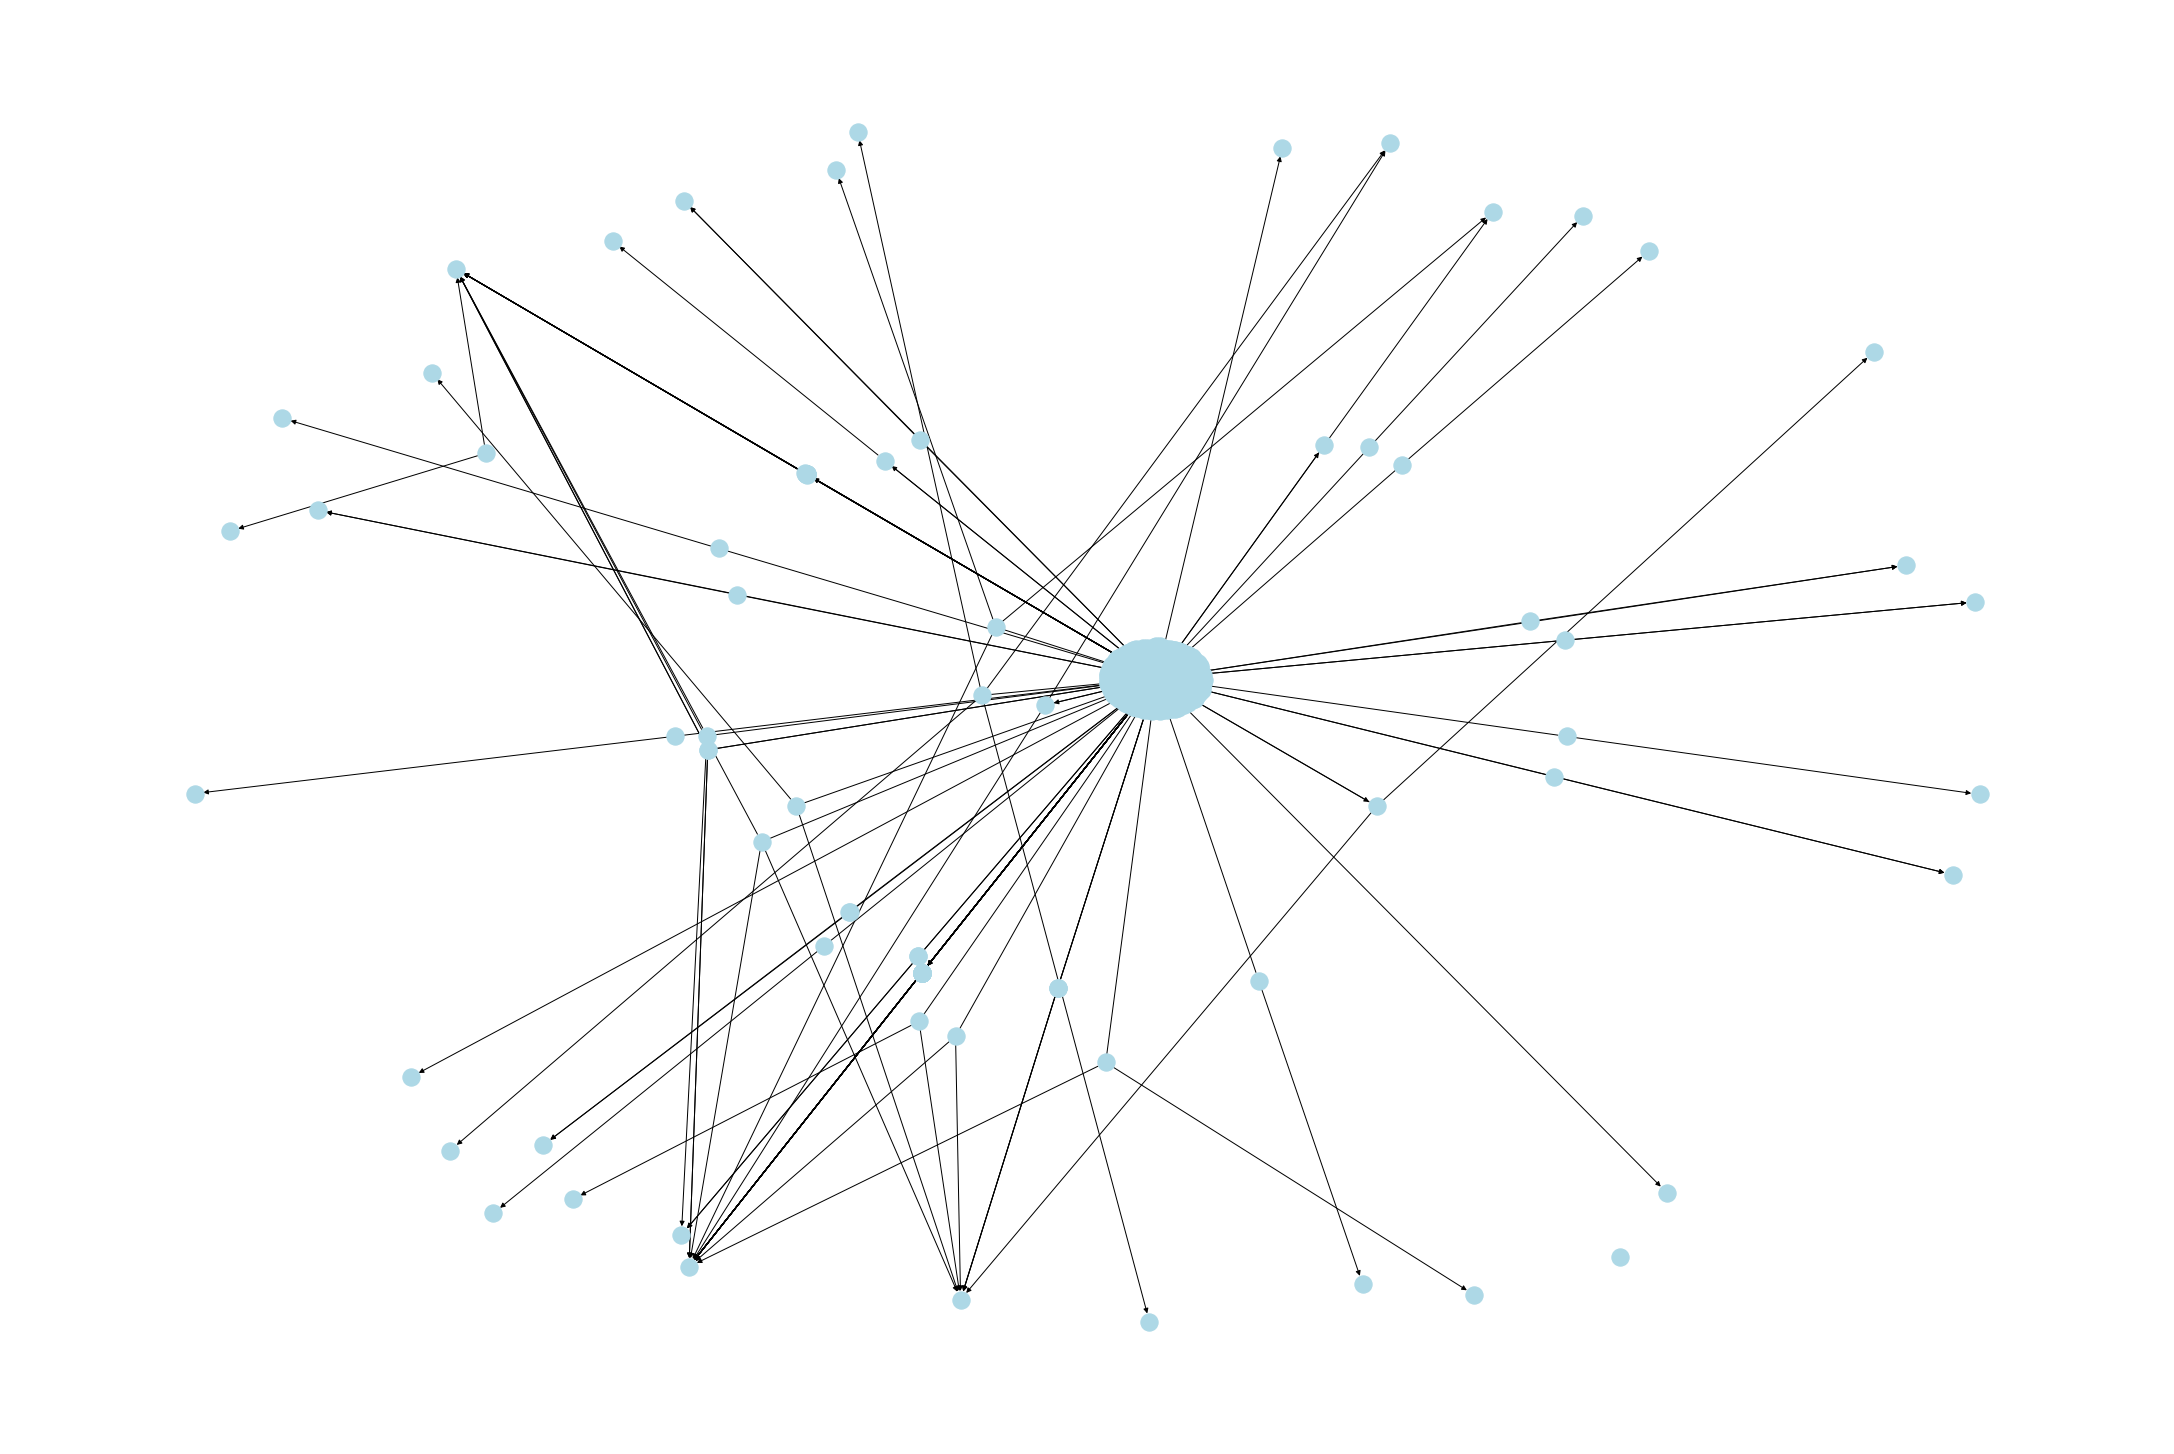

In [43]:
rcParams['figure.figsize'] = 30, 20
pos = nx.spring_layout(G, scale=0.15, k=0.5/np.sqrt(G.order()))
nx.draw(G, pos, node_color='lightblue')

In [44]:
degree_centrality=pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').reset_index()
degree_centrality

index         0
0     Uber_Support  1.057940
1    wordofbrandon  0.002146
2        CapeVgirl  0.002146
3     SatishInnov8  0.004292
4       realchetty  0.004292
..             ...       ...
462   aIonelynight  0.002146
463       ImAndreM  0.002146
464   hegemonprime  0.002146
465      jstocks21  0.002146
466       matdel69  0.002146

[467 rows x 2 columns]

In [45]:
closeness_centrality=pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index').reset_index()
closeness_centrality

index         0
0     Uber_Support  0.927039
1    wordofbrandon  0.465129
2        CapeVgirl  0.465129
3     SatishInnov8  0.000000
4       realchetty  0.464056
..             ...       ...
462   aIonelynight  0.000000
463       ImAndreM  0.000000
464   hegemonprime  0.000000
465      jstocks21  0.000000
466       matdel69  0.465129

[467 rows x 2 columns]

In [46]:
betweenness_centrality=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').reset_index()
betweenness_centrality

index         0
0     Uber_Support  0.135055
1    wordofbrandon  0.000000
2        CapeVgirl  0.000000
3     SatishInnov8  0.000000
4       realchetty  0.000000
..             ...       ...
462   aIonelynight  0.000000
463       ImAndreM  0.000000
464   hegemonprime  0.000000
465      jstocks21  0.000000
466       matdel69  0.000000

[467 rows x 2 columns]

In [47]:
load_centrality=pd.DataFrame.from_dict(nx.load_centrality(G), orient='index').reset_index()
load_centrality

index         0
0     Uber_Support  0.135055
1    wordofbrandon  0.000000
2        CapeVgirl  0.000000
3     SatishInnov8  0.000000
4       realchetty  0.000000
..             ...       ...
462   aIonelynight  0.000000
463       ImAndreM  0.000000
464   hegemonprime  0.000000
465      jstocks21  0.000000
466       matdel69  0.000000

[467 rows x 2 columns]

In [48]:
eigenvector_centrality=pd.DataFrame.from_dict(nx.eigenvector_centrality(G), orient='index').reset_index()
eigenvector_centrality

index             0
0     Uber_Support  6.804193e-01
1    wordofbrandon  9.346773e-02
2        CapeVgirl  9.346773e-02
3     SatishInnov8  2.936586e-37
4       realchetty  9.346773e-02
..             ...           ...
462   aIonelynight  2.936586e-37
463       ImAndreM  2.936586e-37
464   hegemonprime  2.936586e-37
465      jstocks21  2.936586e-37
466       matdel69  9.346773e-02

[467 rows x 2 columns]

In [49]:
network_measures = degree_centrality.merge(closeness_centrality, on='index').merge(betweenness_centrality, on='index').merge(load_centrality, on='index').merge(eigenvector_centrality, on='index')
network_measures

index       0_x       0_y       0_x       0_y             0
0     Uber_Support  1.057940  0.927039  0.135055  0.135055  6.804193e-01
1    wordofbrandon  0.002146  0.465129  0.000000  0.000000  9.346773e-02
2        CapeVgirl  0.002146  0.465129  0.000000  0.000000  9.346773e-02
3     SatishInnov8  0.004292  0.000000  0.000000  0.000000  2.936586e-37
4       realchetty  0.004292  0.464056  0.000000  0.000000  9.346773e-02
..             ...       ...       ...       ...       ...           ...
462   aIonelynight  0.002146  0.000000  0.000000  0.000000  2.936586e-37
463       ImAndreM  0.002146  0.000000  0.000000  0.000000  2.936586e-37
464   hegemonprime  0.002146  0.000000  0.000000  0.000000  2.936586e-37
465      jstocks21  0.002146  0.000000  0.000000  0.000000  2.936586e-37
466       matdel69  0.002146  0.465129  0.000000  0.000000  9.346773e-02

[467 rows x 6 columns]

In [50]:
network_measures.columns = ['user', 'degree', 'closeness', 'betweenness', 'load', 'eigenvector'] # Consistent formatting

In [51]:
network_measures = network_measures.merge(users_df, on='user') # Merge on unique user name
network_measures

user    degree  closeness  betweenness      load   eigenvector  \
0     Uber_Support  1.057940   0.927039     0.135055  0.135055  6.804193e-01   
1    wordofbrandon  0.002146   0.465129     0.000000  0.000000  9.346773e-02   
2        CapeVgirl  0.002146   0.465129     0.000000  0.000000  9.346773e-02   
3     SatishInnov8  0.004292   0.000000     0.000000  0.000000  2.936586e-37   
4       realchetty  0.004292   0.464056     0.000000  0.000000  9.346773e-02   
..             ...       ...        ...          ...       ...           ...   
462   aIonelynight  0.002146   0.000000     0.000000  0.000000  2.936586e-37   
463       ImAndreM  0.002146   0.000000     0.000000  0.000000  2.936586e-37   
464   hegemonprime  0.002146   0.000000     0.000000  0.000000  2.936586e-37   
465      jstocks21  0.002146   0.000000     0.000000  0.000000  2.936586e-37   
466       matdel69  0.002146   0.465129     0.000000  0.000000  9.346773e-02   

     listed  followers  reply_sent  reply_recieved  mention_sent  \
0       523     591423         1.0           480.0           0.0   
1        56      24501         1.0           480.0           0.0   
2         9        133         1.0           480.0           0.0   
3         1        441         1.0           480.0           0.0   
4         1        138        98.0             1.0           0.0   
..      ...        ...         ...             ...           ...   
462      56       5007         1.0           480.0           0.0   
463       6        273         1.0           480.0           0.0   
464      33        295         1.0           480.0           0.0   
465       7        342        98.0             2.0           0.0   
466       0          1         0.0             0.0           0.0   

     mention_recieved  tweet_sent  tweet_recieved  
0                 0.0         0.0             0.0  
1                 0.0         0.0             0.0  
2                 0.0         0.0             0.0  
3                 0.0         0.0             0.0  
4                 0.0         0.0             0.0  
..                ...         ...             ...  
462               0.0         0.0             0.0  
463               0.0         0.0             0.0  
464               0.0         0.0             0.0  
465               0.0         0.0             0.0  
466               0.0         0.0             0.0  

[467 rows x 14 columns]

In [52]:
network_measures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 467 entries, 0 to 466
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user              467 non-null    object 
 1   degree            467 non-null    float64
 2   closeness         467 non-null    float64
 3   betweenness       467 non-null    float64
 4   load              467 non-null    float64
 5   eigenvector       467 non-null    float64
 6   listed            467 non-null    int64  
 7   followers         467 non-null    int64  
 8   reply_sent        467 non-null    float64
 9   reply_recieved    467 non-null    float64
 10  mention_sent      467 non-null    float64
 11  mention_recieved  467 non-null    float64
 12  tweet_sent        467 non-null    float64
 13  tweet_recieved    467 non-null    float64
dtypes: float64(11), int64(2), object(1)
memory usage: 54.7+ KB


In [53]:
network_measures.set_index('user', inplace=True)

In [54]:
# Normalize
scaled_features = MinMaxScaler().fit_transform(network_measures.values)

In [55]:
normalized_network_measures = pd.DataFrame(scaled_features, index=network_measures.index, columns=network_measures.columns)
normalized_network_measures

degree  closeness  betweenness  load  eigenvector    listed  \
user                                                                           
Uber_Support   1.000000   1.000000          1.0   1.0     1.000000  0.003540   
wordofbrandon  0.000000   0.501737          0.0   0.0     0.137368  0.000379   
CapeVgirl      0.000000   0.501737          0.0   0.0     0.137368  0.000061   
SatishInnov8   0.002033   0.000000          0.0   0.0     0.000000  0.000007   
realchetty     0.002033   0.500579          0.0   0.0     0.137368  0.000007   
...                 ...        ...          ...   ...          ...       ...   
aIonelynight   0.000000   0.000000          0.0   0.0     0.000000  0.000379   
ImAndreM       0.000000   0.000000          0.0   0.0     0.000000  0.000041   
hegemonprime   0.000000   0.000000          0.0   0.0     0.000000  0.000223   
jstocks21      0.000000   0.000000          0.0   0.0     0.000000  0.000047   
matdel69       0.000000   0.501737          0.0   0.0     0.137368  0.000000   

                  followers  reply_sent  reply_recieved  mention_sent  \
user                                                                    
Uber_Support   1.107832e-02    0.010204        1.000000           0.0   
wordofbrandon  4.589439e-04    0.010204        1.000000           0.0   
CapeVgirl      2.491308e-06    0.010204        1.000000           0.0   
SatishInnov8   8.260653e-06    0.010204        1.000000           0.0   
realchetty     2.584966e-06    1.000000        0.002083           0.0   
...                     ...         ...             ...           ...   
aIonelynight   9.378932e-05    0.010204        1.000000           0.0   
ImAndreM       5.113738e-06    0.010204        1.000000           0.0   
hegemonprime   5.525834e-06    0.010204        1.000000           0.0   
jstocks21      6.406221e-06    1.000000        0.004167           0.0   
matdel69       1.873164e-08    0.000000        0.000000           0.0   

               mention_recieved  tweet_sent  tweet_recieved  
user                                                         
Uber_Support                0.0         0.0             0.0  
wordofbrandon               0.0         0.0             0.0  
CapeVgirl                   0.0         0.0             0.0  
SatishInnov8                0.0         0.0             0.0  
realchetty                  0.0         0.0             0.0  
...                         ...         ...             ...  
aIonelynight                0.0         0.0             0.0  
ImAndreM                    0.0         0.0             0.0  
hegemonprime                0.0         0.0             0.0  
jstocks21                   0.0         0.0             0.0  
matdel69                    0.0         0.0             0.0  

[467 rows x 13 columns]

In [56]:
sel = VarianceThreshold(threshold=0.0005)
network_measures_sel = sel.fit_transform(normalized_network_measures)
network_measures_sel

array([[1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.50173678, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.50173678, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00416667, 0.        ,
        0.        ],
       [0.        , 0.50173678, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [57]:
normalized_network_sel_measures = pd.DataFrame(network_measures_sel, index=network_measures.index, columns=['s'+str(i) for i in range(len(network_measures_sel[0]))])
normalized_network_sel_measures

s0        s1   s2   s3        s4        s5            s6  \
user                                                                            
Uber_Support   1.000000  1.000000  1.0  1.0  1.000000  0.003540  1.107832e-02   
wordofbrandon  0.000000  0.501737  0.0  0.0  0.137368  0.000379  4.589439e-04   
CapeVgirl      0.000000  0.501737  0.0  0.0  0.137368  0.000061  2.491308e-06   
SatishInnov8   0.002033  0.000000  0.0  0.0  0.000000  0.000007  8.260653e-06   
realchetty     0.002033  0.500579  0.0  0.0  0.137368  0.000007  2.584966e-06   
...                 ...       ...  ...  ...       ...       ...           ...   
aIonelynight   0.000000  0.000000  0.0  0.0  0.000000  0.000379  9.378932e-05   
ImAndreM       0.000000  0.000000  0.0  0.0  0.000000  0.000041  5.113738e-06   
hegemonprime   0.000000  0.000000  0.0  0.0  0.000000  0.000223  5.525834e-06   
jstocks21      0.000000  0.000000  0.0  0.0  0.000000  0.000047  6.406221e-06   
matdel69       0.000000  0.501737  0.0  0.0  0.137368  0.000000  1.873164e-08   

                     s7        s8   s9  s10  
user                                         
Uber_Support   0.010204  1.000000  0.0  0.0  
wordofbrandon  0.010204  1.000000  0.0  0.0  
CapeVgirl      0.010204  1.000000  0.0  0.0  
SatishInnov8   0.010204  1.000000  0.0  0.0  
realchetty     1.000000  0.002083  0.0  0.0  
...                 ...       ...  ...  ...  
aIonelynight   0.010204  1.000000  0.0  0.0  
ImAndreM       0.010204  1.000000  0.0  0.0  
hegemonprime   0.010204  1.000000  0.0  0.0  
jstocks21      1.000000  0.004167  0.0  0.0  
matdel69       0.000000  0.000000  0.0  0.0  

[467 rows x 11 columns]

In [58]:
col_names = normalized_network_measures.columns
col_names = col_names.insert(0, 'mean_score')
col_names = col_names.insert(0, 'sum_score')

In [59]:
normalized_network_measures['mean_score'] = normalized_network_sel_measures[:].mean(axis=1)
normalized_network_measures['mean_score']

user
Uber_Support     0.547711
wordofbrandon    0.150013
CapeVgirl        0.149943
SatishInnov8     0.092023
realchetty       0.149279
                   ...   
aIonelynight     0.091880
ImAndreM         0.091841
hegemonprime     0.091858
jstocks21        0.091293
matdel69         0.058100
Name: mean_score, Length: 467, dtype: float64

In [60]:
normalized_network_measures['sum_score'] = normalized_network_sel_measures[:].mean(axis=1)
normalized_network_measures['sum_score']

user
Uber_Support     0.547711
wordofbrandon    0.150013
CapeVgirl        0.149943
SatishInnov8     0.092023
realchetty       0.149279
                   ...   
aIonelynight     0.091880
ImAndreM         0.091841
hegemonprime     0.091858
jstocks21        0.091293
matdel69         0.058100
Name: sum_score, Length: 467, dtype: float64

In [61]:
# Sort
results = normalized_network_measures.sort_values(by='mean_score', ascending=False)
results

degree  closeness  betweenness      load   eigenvector  \
user                                                                        
Uber_Support     1.000000   1.000000     1.000000  1.000000  1.000000e+00   
CNN              0.000000   0.002315     0.000000  0.000000  1.640022e-35   
SocialistBooks   0.000000   0.000000     0.000000  0.000000  0.000000e+00   
gregory_finney   0.006098   0.500579     0.029284  0.029284  1.373678e-01   
lordsarcastico   0.006098   0.500579     0.018213  0.018213  1.373678e-01   
...                   ...        ...          ...       ...           ...   
DJRiddle27       0.000000   0.000000     0.000000  0.000000  0.000000e+00   
FrankieAloysius  0.000000   0.000000     0.000000  0.000000  0.000000e+00   
colaqveen        0.000000   0.000000     0.000000  0.000000  0.000000e+00   
Umar_nr          0.000000   0.000000     0.000000  0.000000  0.000000e+00   
UberINSupport    0.004065   0.006944     0.000000  0.000000  4.920066e-35   

                   listed     followers  reply_sent  reply_recieved  \
user                                                                  
Uber_Support     0.003540  1.107832e-02    0.010204        1.000000   
CNN              1.000000  1.000000e+00    0.030612        0.054167   
SocialistBooks   0.000393  1.762647e-05    0.000000        0.000000   
gregory_finney   0.000277  2.165378e-05    0.010204        1.000000   
lordsarcastico   0.000210  1.790745e-05    1.000000        0.004167   
...                   ...           ...         ...             ...   
DJRiddle27       0.000007  7.867289e-07    0.020408        0.002083   
FrankieAloysius  0.000007  6.556074e-07    0.020408        0.002083   
colaqveen        0.000000  7.679973e-07    0.020408        0.002083   
Umar_nr          0.000000  4.308277e-07    0.020408        0.002083   
UberINSupport    0.000244  8.199588e-04    0.000000        0.000000   

                 mention_sent  mention_recieved  tweet_sent  tweet_recieved  \
user                                                                          
Uber_Support              0.0               0.0         0.0             0.0   
CNN                       0.0               0.0         0.0             0.0   
SocialistBooks            0.0               0.0         1.0             1.0   
gregory_finney            0.0               0.0         0.0             0.0   
lordsarcastico            0.0               0.0         0.0             0.0   
...                       ...               ...         ...             ...   
DJRiddle27                0.0               0.0         0.0             0.0   
FrankieAloysius           0.0               0.0         0.0             0.0   
colaqveen                 0.0               0.0         0.0             0.0   
Umar_nr                   0.0               0.0         0.0             0.0   
UberINSupport             0.0               0.0         0.0             0.0   

                 mean_score  sum_score  
user                                    
Uber_Support       0.547711   0.547711  
CNN                0.189736   0.189736  
SocialistBooks     0.181855   0.181855  
gregory_finney     0.155738   0.155738  
lordsarcastico     0.153170   0.153170  
...                     ...        ...  
DJRiddle27         0.002045   0.002045  
FrankieAloysius    0.002045   0.002045  
colaqveen          0.002045   0.002045  
Umar_nr            0.002045   0.002045  
UberINSupport      0.001098   0.001098  

[467 rows x 15 columns]

In [62]:
normalized_network_measures = normalized_network_measures.reindex(columns=col_names)

In [63]:
nx.voterank(G)

['Uber_Support',
 'StlGig',
 'jamesmicheallec',
 'Deekshikoppa',
 'James_Carleton',
 'ivipankumar',
 'jbanksbell',
 'pujappathak',
 'RahulPadha5',
 'JfpFor',
 'I_said_Uhh',
 'gregory_finney',
 'madisongkk',
 'QueenWordsmith',
 'AdrianaStills',
 'roudettej',
 'KeiraFoSho',
 'Jtwites1',
 'TonyDofat',
 'KelleyCabbana',
 'Bolt__fx',
 'ThatTiredOne14',
 'TajinderBagga',
 'huzi1502',
 'ithnkimparanoid',
 'vilacron',
 'totallyyeswow',
 'Inabees',
 'GardeGar',
 'lordsarcastico']

In [64]:
# results.to_csv(r'.\data\pre_network_results.csv')
results.to_csv('./data/pre_network_results.csv')

# Post-COVID

In [65]:
users_df = users_df_copy.copy() # Per user data
uber_df = uber_df_copy.copy()

In [66]:
uber_df = uber_df[uber_df['created_at'] > covid_date]

In [67]:
# Calculate types per user
users_df['reply_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('source')['type_of_content'].transform('count'))
users_df['reply_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Reply'].groupby('target')['type_of_content'].transform('count'))
users_df['mention_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('source')['type_of_content'].transform('count'))
users_df['mention_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Mention'].groupby('target')['type_of_content'].transform('count'))
users_df['tweet_sent'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('source')['type_of_content'].transform('count'))
users_df['tweet_recieved'] = pd.to_numeric(uber_df[uber_df['type_of_content'] == 'Tweet'].groupby('target')['type_of_content'].transform('count'))

In [68]:
users_df.fillna(0, inplace=True) # Consitency
users_df

user  listed  followers  reply_sent  reply_recieved  \
0     Michael05914091       0          8         0.0             0.0   
1           ShieldVoC      18      17566         0.0             0.0   
2             fltrtae      15       1717         0.0             0.0   
3       Lucky00890359       0          0         0.0             0.0   
4     zhenyalindgardt       1         55         0.0             0.0   
...               ...     ...        ...         ...             ...   
2573    fayedicksonxo       0        213         1.0          2646.0   
2574     Iam_bahuguna       0         90         1.0          2646.0   
2575         ajb_neuk       0          3         0.0             0.0   
2576           k_sovs       0          2         0.0             0.0   
2577        MY0U1SANA      22       3946         1.0          2646.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2573           0.0               0.0         0.0             0.0  
2574           0.0               0.0         0.0             0.0  
2575           8.0             115.0         0.0             0.0  
2576           8.0               2.0         0.0             0.0  
2577           0.0               0.0         0.0             0.0  

[2578 rows x 9 columns]

In [69]:
# Create network
G = nx.DiGraph()

edges = list()
for (a,b) in zip(uber_df['source'], uber_df['target']):
    edges.append((a,b))

G.add_edges_from(edges)
G

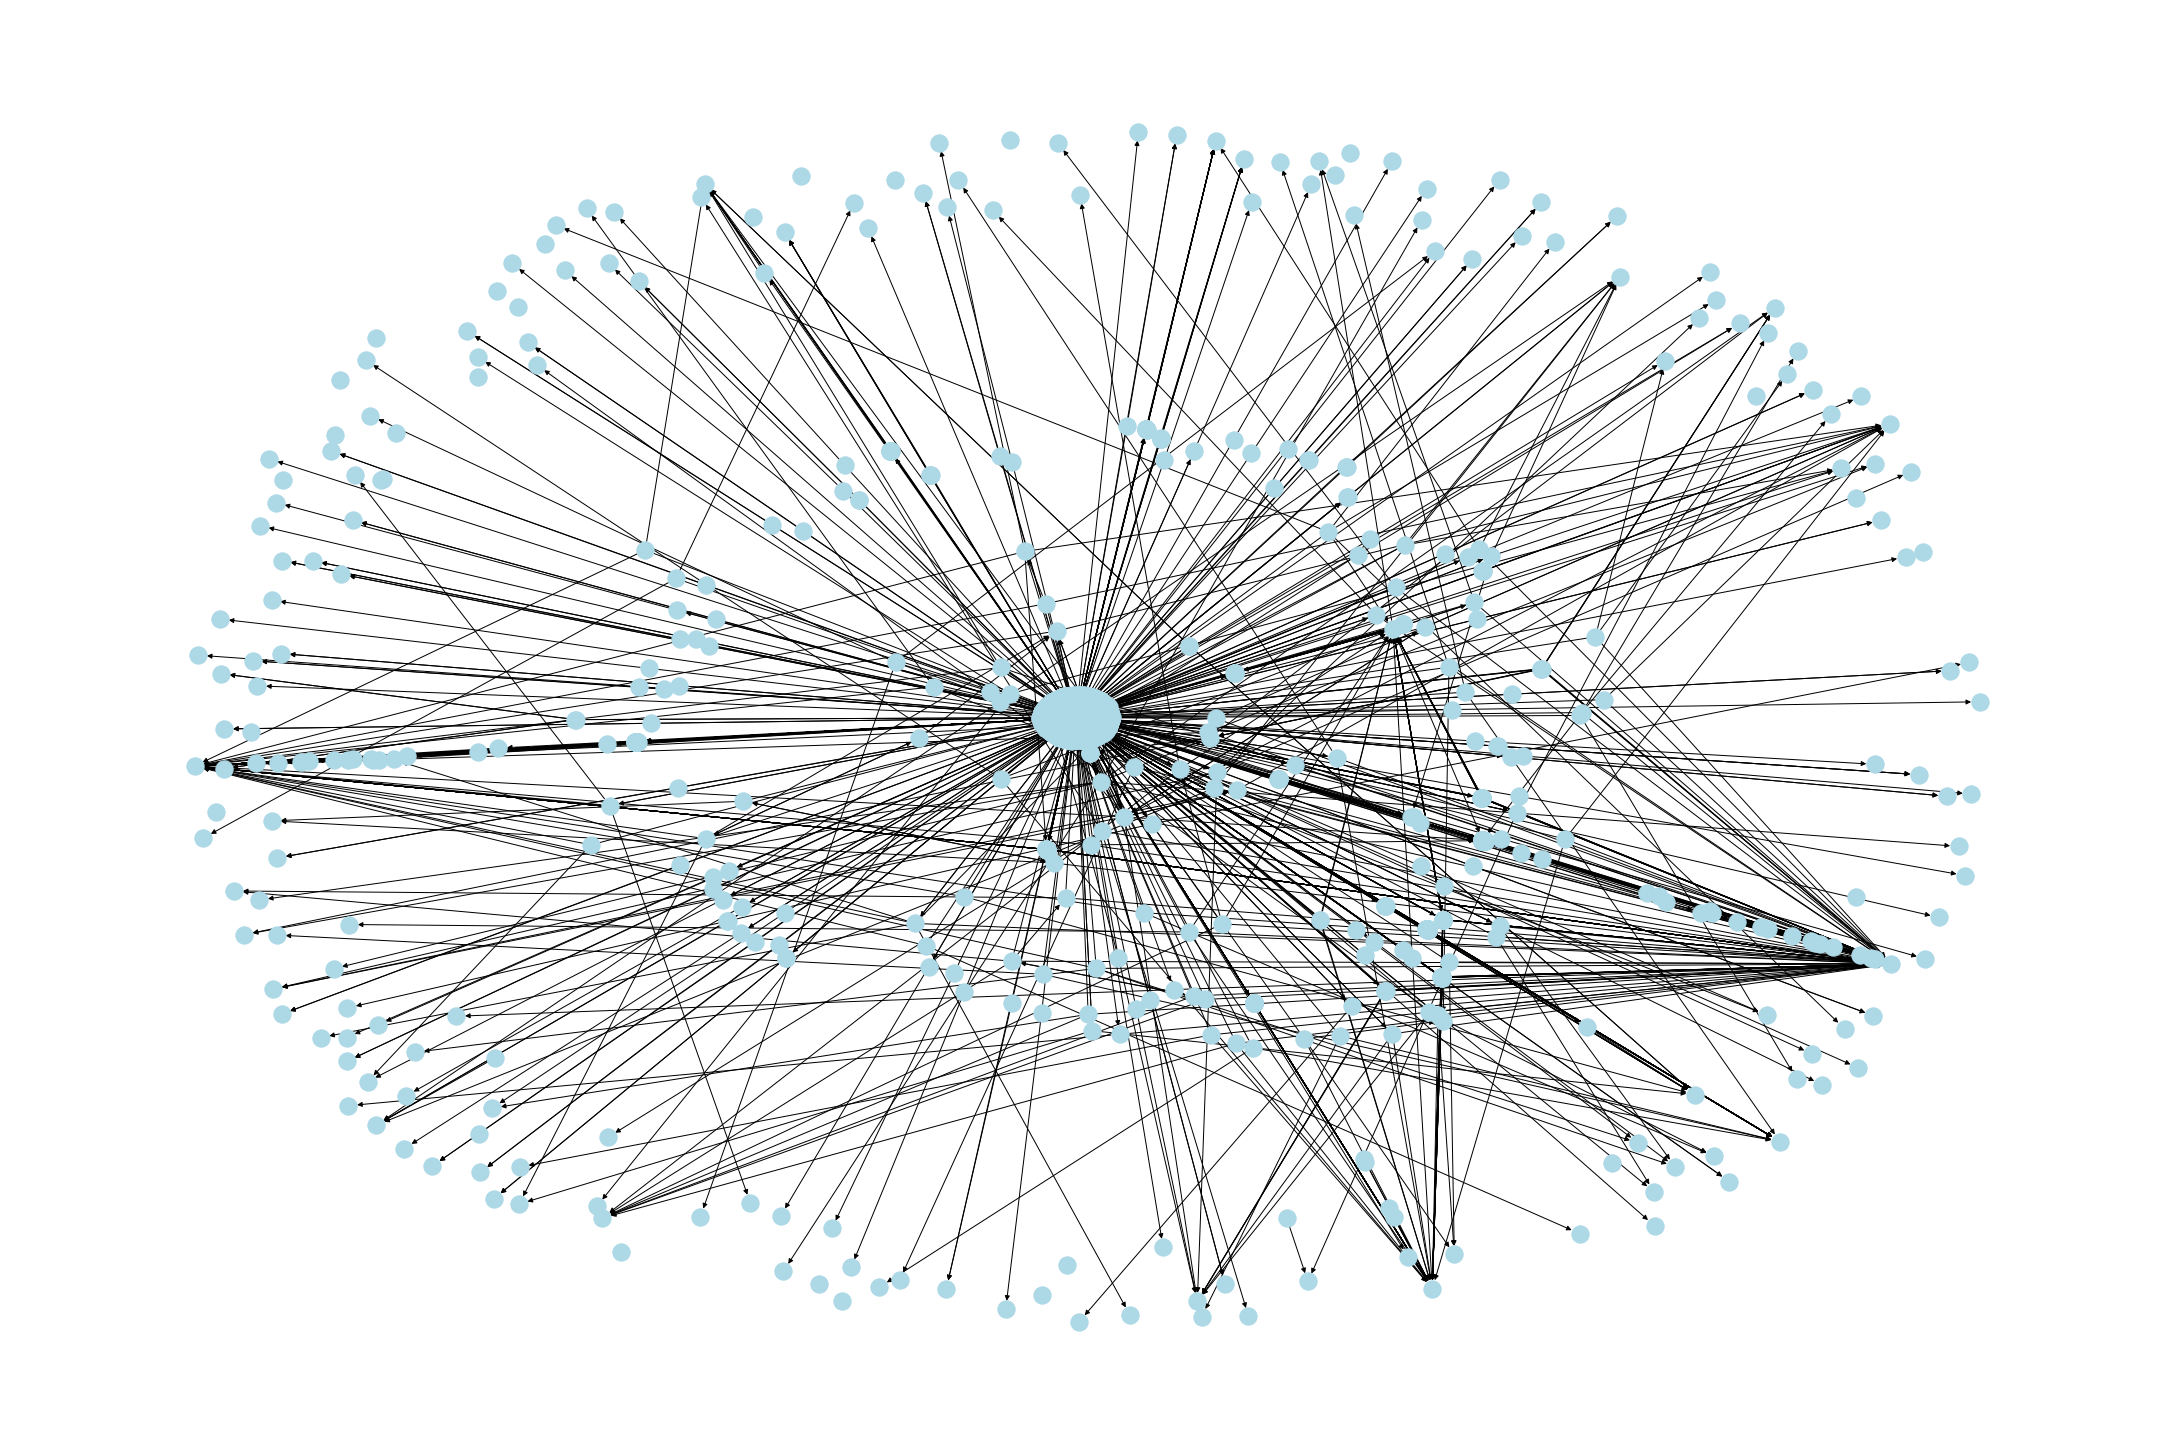

In [70]:
rcParams['figure.figsize'] = 30, 20
pos = nx.spring_layout(G, scale=0.15, k=0.5/np.sqrt(G.order()))
nx.draw(G, pos, node_color='lightblue')

In [71]:
degree_centrality=pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index').reset_index()
degree_centrality

index         0
0        Uber_Support  1.241331
1             fltrtae  0.012652
2     Michael05914091  0.000937
3          maybeharsh  0.000937
4          Lbabyrouth  0.001406
...               ...       ...
2130          Nezz911  0.001406
2131      NeoVonAxiom  0.000469
2132         ajb_neuk  0.000937
2133     Iam_bahuguna  0.000469
2134        MY0U1SANA  0.000937

[2135 rows x 2 columns]

In [72]:
closeness_centrality=pd.DataFrame.from_dict(nx.closeness_centrality(G), orient='index').reset_index()
closeness_centrality

index         0
0        Uber_Support  0.883834
1             fltrtae  0.446936
2     Michael05914091  0.444006
3          maybeharsh  0.443656
4          Lbabyrouth  0.444123
...               ...       ...
2130          Nezz911  0.443656
2131      NeoVonAxiom  0.000000
2132         ajb_neuk  0.443656
2133     Iam_bahuguna  0.000000
2134        MY0U1SANA  0.000000

[2135 rows x 2 columns]

In [73]:
betweenness_centrality=pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index').reset_index()
betweenness_centrality

index         0
0        Uber_Support  0.337344
1             fltrtae  0.000000
2     Michael05914091  0.000000
3          maybeharsh  0.000000
4          Lbabyrouth  0.000000
...               ...       ...
2130          Nezz911  0.000015
2131      NeoVonAxiom  0.000000
2132         ajb_neuk  0.000000
2133     Iam_bahuguna  0.000000
2134        MY0U1SANA  0.000000

[2135 rows x 2 columns]

In [74]:
load_centrality=pd.DataFrame.from_dict(nx.load_centrality(G), orient='index').reset_index()
load_centrality

index         0
0        Uber_Support  0.337344
1             fltrtae  0.000000
2     Michael05914091  0.000000
3          maybeharsh  0.000000
4          Lbabyrouth  0.000000
...               ...       ...
2130          Nezz911  0.000015
2131      NeoVonAxiom  0.000000
2132         ajb_neuk  0.000000
2133     Iam_bahuguna  0.000000
2134        MY0U1SANA  0.000000

[2135 rows x 2 columns]

In [75]:
eigenvector_centrality=pd.DataFrame.from_dict(nx.eigenvector_centrality(G), orient='index').reset_index()
eigenvector_centrality

index              0
0        Uber_Support   6.948256e-01
1             fltrtae   2.609030e-02
2     Michael05914091   2.609030e-02
3          maybeharsh   2.609030e-02
4          Lbabyrouth   2.609030e-02
...               ...            ...
2130          Nezz911   2.609030e-02
2131      NeoVonAxiom  2.051762e-126
2132         ajb_neuk   2.609030e-02
2133     Iam_bahuguna  2.051762e-126
2134        MY0U1SANA  2.051762e-126

[2135 rows x 2 columns]

In [76]:
network_measures = degree_centrality.merge(closeness_centrality, on='index').merge(betweenness_centrality, on='index').merge(load_centrality, on='index').merge(eigenvector_centrality, on='index')
network_measures

index       0_x       0_y       0_x       0_y              0
0        Uber_Support  1.241331  0.883834  0.337344  0.337344   6.948256e-01
1             fltrtae  0.012652  0.446936  0.000000  0.000000   2.609030e-02
2     Michael05914091  0.000937  0.444006  0.000000  0.000000   2.609030e-02
3          maybeharsh  0.000937  0.443656  0.000000  0.000000   2.609030e-02
4          Lbabyrouth  0.001406  0.444123  0.000000  0.000000   2.609030e-02
...               ...       ...       ...       ...       ...            ...
2130          Nezz911  0.001406  0.443656  0.000015  0.000015   2.609030e-02
2131      NeoVonAxiom  0.000469  0.000000  0.000000  0.000000  2.051762e-126
2132         ajb_neuk  0.000937  0.443656  0.000000  0.000000   2.609030e-02
2133     Iam_bahuguna  0.000469  0.000000  0.000000  0.000000  2.051762e-126
2134        MY0U1SANA  0.000937  0.000000  0.000000  0.000000  2.051762e-126

[2135 rows x 6 columns]

In [77]:
network_measures.columns = ['user', 'degree', 'closeness', 'betweenness', 'load', 'eigenvector'] # Consistent formatting

In [78]:
network_measures = network_measures.merge(users_df, on='user') # Merge on unique user name
network_measures

user    degree  closeness  betweenness      load  \
0        Uber_Support  1.241331   0.883834     0.337344  0.337344   
1             fltrtae  0.012652   0.446936     0.000000  0.000000   
2     Michael05914091  0.000937   0.444006     0.000000  0.000000   
3          maybeharsh  0.000937   0.443656     0.000000  0.000000   
4          Lbabyrouth  0.001406   0.444123     0.000000  0.000000   
...               ...       ...        ...          ...       ...   
2124          Nezz911  0.001406   0.443656     0.000015  0.000015   
2125      NeoVonAxiom  0.000469   0.000000     0.000000  0.000000   
2126         ajb_neuk  0.000937   0.443656     0.000000  0.000000   
2127     Iam_bahuguna  0.000469   0.000000     0.000000  0.000000   
2128        MY0U1SANA  0.000937   0.000000     0.000000  0.000000   

        eigenvector  listed  followers  reply_sent  reply_recieved  \
0      6.948256e-01     523     591423         0.0             0.0   
1      2.609030e-02      15       1717         0.0             0.0   
2      2.609030e-02       0          8         0.0             0.0   
3      2.609030e-02       0          0         1.0          2646.0   
4      2.609030e-02       0         23         0.0             0.0   
...             ...     ...        ...         ...             ...   
2124   2.609030e-02       4        658         2.0           111.0   
2125  2.051762e-126       0          4        13.0          2646.0   
2126   2.609030e-02       0          3         0.0             0.0   
2127  2.051762e-126       0         90         1.0          2646.0   
2128  2.051762e-126      22       3946         1.0          2646.0   

      mention_sent  mention_recieved  tweet_sent  tweet_recieved  
0              0.0               0.0         0.0             0.0  
1              0.0               0.0         0.0             0.0  
2              0.0               0.0         0.0             0.0  
3              0.0               0.0         0.0             0.0  
4              0.0               0.0         0.0             0.0  
...            ...               ...         ...             ...  
2124           0.0               0.0         0.0             0.0  
2125           0.0               0.0         0.0             0.0  
2126           8.0             115.0         0.0             0.0  
2127           0.0               0.0         0.0             0.0  
2128           0.0               0.0         0.0             0.0  

[2129 rows x 14 columns]

In [79]:
network_measures.set_index('user', inplace=True)

In [80]:
# Normalize
scaled_features = MinMaxScaler().fit_transform(network_measures.values)

In [81]:
normalized_network_measures = pd.DataFrame(scaled_features, index=network_measures.index, columns=network_measures.columns)
normalized_network_measures

degree  closeness  betweenness      load  eigenvector  \
user                                                                       
Uber_Support     1.000000   1.000000     1.000000  1.000000     1.000000   
fltrtae          0.009819   0.505678     0.000000  0.000000     0.037549   
Michael05914091  0.000378   0.502364     0.000000  0.000000     0.037549   
maybeharsh       0.000378   0.501967     0.000000  0.000000     0.037549   
Lbabyrouth       0.000755   0.502495     0.000000  0.000000     0.037549   
...                   ...        ...          ...       ...          ...   
Nezz911          0.000755   0.501967     0.000044  0.000044     0.037549   
NeoVonAxiom      0.000000   0.000000     0.000000  0.000000     0.000000   
ajb_neuk         0.000378   0.501967     0.000000  0.000000     0.037549   
Iam_bahuguna     0.000000   0.000000     0.000000  0.000000     0.000000   
MY0U1SANA        0.000378   0.000000     0.000000  0.000000     0.000000   

                   listed     followers  reply_sent  reply_recieved  \
user                                                                  
Uber_Support     0.020191  2.723194e-02    0.000000         0.00000   
fltrtae          0.000579  7.905887e-05    0.000000         0.00000   
Michael05914091  0.000000  3.683582e-07    0.000000         0.00000   
maybeharsh       0.000000  0.000000e+00    0.000951         1.00000   
Lbabyrouth       0.000000  1.059030e-06    0.000000         0.00000   
...                   ...           ...         ...             ...   
Nezz911          0.000154  3.029746e-05    0.001903         0.04195   
NeoVonAxiom      0.000000  1.841791e-07    0.012369         1.00000   
ajb_neuk         0.000000  1.381343e-07    0.000000         0.00000   
Iam_bahuguna     0.000000  4.144029e-06    0.000951         1.00000   
MY0U1SANA        0.000849  1.816927e-04    0.000951         1.00000   

                 mention_sent  mention_recieved  tweet_sent  tweet_recieved  
user                                                                         
Uber_Support         0.000000               0.0         0.0             0.0  
fltrtae              0.000000               0.0         0.0             0.0  
Michael05914091      0.000000               0.0         0.0             0.0  
maybeharsh           0.000000               0.0         0.0             0.0  
Lbabyrouth           0.000000               0.0         0.0             0.0  
...                       ...               ...         ...             ...  
Nezz911              0.000000               0.0         0.0             0.0  
NeoVonAxiom          0.000000               0.0         0.0             0.0  
ajb_neuk             0.615385               1.0         0.0             0.0  
Iam_bahuguna         0.000000               0.0         0.0             0.0  
MY0U1SANA            0.000000               0.0         0.0             0.0  

[2129 rows x 13 columns]

In [82]:
sel = VarianceThreshold(threshold=0.0005)
network_measures_sel = sel.fit_transform(normalized_network_measures)
network_measures_sel

array([[1.00000000e+00, 1.00000000e+00, 2.01914910e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.05678350e-01, 3.75494295e-02, 5.79105861e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.02363730e-01, 3.75494295e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.01966955e-01, 3.75494295e-02, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.49355262e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [83]:
normalized_network_sel_measures = pd.DataFrame(network_measures_sel, index=network_measures.index, columns=['s'+str(i) for i in range(len(network_measures_sel[0]))])
normalized_network_sel_measures

s0        s1        s2            s3        s4  \
user                                                                    
Uber_Support     1.000000  1.000000  0.020191  2.723194e-02  0.000000   
fltrtae          0.505678  0.037549  0.000579  7.905887e-05  0.000000   
Michael05914091  0.502364  0.037549  0.000000  3.683582e-07  0.000000   
maybeharsh       0.501967  0.037549  0.000000  0.000000e+00  0.000951   
Lbabyrouth       0.502495  0.037549  0.000000  1.059030e-06  0.000000   
...                   ...       ...       ...           ...       ...   
Nezz911          0.501967  0.037549  0.000154  3.029746e-05  0.001903   
NeoVonAxiom      0.000000  0.000000  0.000000  1.841791e-07  0.012369   
ajb_neuk         0.501967  0.037549  0.000000  1.381343e-07  0.000000   
Iam_bahuguna     0.000000  0.000000  0.000000  4.144029e-06  0.000951   
MY0U1SANA        0.000000  0.000000  0.000849  1.816927e-04  0.000951   

                      s5        s6   s7   s8   s9  
user                                               
Uber_Support     0.00000  0.000000  0.0  0.0  0.0  
fltrtae          0.00000  0.000000  0.0  0.0  0.0  
Michael05914091  0.00000  0.000000  0.0  0.0  0.0  
maybeharsh       1.00000  0.000000  0.0  0.0  0.0  
Lbabyrouth       0.00000  0.000000  0.0  0.0  0.0  
...                  ...       ...  ...  ...  ...  
Nezz911          0.04195  0.000000  0.0  0.0  0.0  
NeoVonAxiom      1.00000  0.000000  0.0  0.0  0.0  
ajb_neuk         0.00000  0.615385  1.0  0.0  0.0  
Iam_bahuguna     1.00000  0.000000  0.0  0.0  0.0  
MY0U1SANA        1.00000  0.000000  0.0  0.0  0.0  

[2129 rows x 10 columns]

In [84]:
col_names = normalized_network_measures.columns
col_names = col_names.insert(0, 'mean_score')
col_names = col_names.insert(0, 'sum_score')

In [85]:
normalized_network_measures['mean_score'] = normalized_network_sel_measures[:].mean(axis=1)
normalized_network_measures['mean_score']

user
Uber_Support       0.204742
fltrtae            0.054389
Michael05914091    0.053991
maybeharsh         0.154047
Lbabyrouth         0.054005
                     ...   
Nezz911            0.058355
NeoVonAxiom        0.101237
ajb_neuk           0.215490
Iam_bahuguna       0.100096
MY0U1SANA          0.100198
Name: mean_score, Length: 2129, dtype: float64

In [86]:
normalized_network_measures['sum_score'] = normalized_network_sel_measures[:].mean(axis=1)
normalized_network_measures['sum_score']

user
Uber_Support       0.204742
fltrtae            0.054389
Michael05914091    0.053991
maybeharsh         0.154047
Lbabyrouth         0.054005
                     ...   
Nezz911            0.058355
NeoVonAxiom        0.101237
ajb_neuk           0.215490
Iam_bahuguna       0.100096
MY0U1SANA          0.100198
Name: sum_score, Length: 2129, dtype: float64

In [87]:
# Sort
results = normalized_network_measures.sort_values(by='mean_score', ascending=False)
results

degree  closeness  betweenness  load  eigenvector  listed  \
user                                                                           
1975aregr8t      0.000378   0.501967          0.0   0.0     0.037549     0.0   
MrsKiraly        0.000378   0.501967          0.0   0.0     0.037549     0.0   
ajb_neuk         0.000378   0.501967          0.0   0.0     0.037549     0.0   
Alex51354835     0.000378   0.501967          0.0   0.0     0.037549     0.0   
SouravBharati    0.000378   0.501967          0.0   0.0     0.037549     0.0   
...                   ...        ...          ...   ...          ...     ...   
Juniortakeo1     0.000000   0.000000          0.0   0.0     0.000000     0.0   
BabylonHoro      0.000000   0.000000          0.0   0.0     0.000000     0.0   
AbdulRa10911356  0.000000   0.000000          0.0   0.0     0.000000     0.0   
Arshdee12667790  0.000000   0.000000          0.0   0.0     0.000000     0.0   
Teh_stephinator  0.000000   0.000000          0.0   0.0     0.000000     0.0   

                    followers  reply_sent  reply_recieved  mention_sent  \
user                                                                      
1975aregr8t      1.703657e-06         0.0             0.0      0.000000   
MrsKiraly        3.223134e-07         0.0             0.0      0.000000   
ajb_neuk         1.381343e-07         0.0             0.0      0.615385   
Alex51354835     4.604477e-08         0.0             0.0      1.000000   
SouravBharati    4.604477e-08         0.0             0.0      1.000000   
...                       ...         ...             ...           ...   
Juniortakeo1     4.604477e-08         0.0             0.0      0.000000   
BabylonHoro      4.604477e-08         0.0             0.0      0.000000   
AbdulRa10911356  0.000000e+00         0.0             0.0      0.000000   
Arshdee12667790  0.000000e+00         0.0             0.0      0.000000   
Teh_stephinator  0.000000e+00         0.0             0.0      0.000000   

                 mention_recieved  tweet_sent  tweet_recieved    mean_score  \
user                                                                          
1975aregr8t              0.000000         1.0             1.0  2.539518e-01   
MrsKiraly                0.000000         1.0             1.0  2.539517e-01   
ajb_neuk                 1.000000         0.0             0.0  2.154901e-01   
Alex51354835             0.565217         0.0             0.0  2.104734e-01   
SouravBharati            0.565217         0.0             0.0  2.104734e-01   
...                           ...         ...             ...           ...   
Juniortakeo1             0.000000         0.0             0.0  4.604477e-09   
BabylonHoro              0.000000         0.0             0.0  4.604477e-09   
AbdulRa10911356          0.000000         0.0             0.0  0.000000e+00   
Arshdee12667790          0.000000         0.0             0.0  0.000000e+00   
Teh_stephinator          0.000000         0.0             0.0  0.000000e+00   

                    sum_score  
user                           
1975aregr8t      2.539518e-01  
MrsKiraly        2.539517e-01  
ajb_neuk         2.154901e-01  
Alex51354835     2.104734e-01  
SouravBharati    2.104734e-01  
...                       ...  
Juniortakeo1     4.604477e-09  
BabylonHoro      4.604477e-09  
AbdulRa10911356  0.000000e+00  
Arshdee12667790  0.000000e+00  
Teh_stephinator  0.000000e+00  

[2129 rows x 15 columns]

In [88]:
normalized_network_measures = normalized_network_measures.reindex(columns=col_names)

In [89]:
# results.to_csv(r'.\data\post_network_results.csv')
results.to_csv('./data/post_network_results.csv')